## setup

In [ ]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [ ]:
soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/2025-06-15_216_tprocv2r24_standard/qick_216.bit')
soccfg = soc
print(soccfg)

## Randomized Benchmarking
RB sequence generator: based on https://github.com/openquantumhardware/devForLBNL/blob/master/RB_code_demo/20220201-3DTransmon-Chacracterization%2BRB.ipynb


In [238]:
import random
from qick.asm_v2 import AveragerProgramV2, AsmV2, AsmInst
from qick.tprocv2_assembler import LFSR

class RBSequenceProgram(AveragerProgramV2):

    def _initialize(self, cfg):

        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']

        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.gates_set = cfg['gates_set']

        # Generate minimum length gaussian pulses
        self.gauss_len = self.cycles2us(3, gen_ch=gen_ch)
        self.add_gauss(ch=gen_ch, name="gauss_env", sigma=self.gauss_len/10, length=self.gauss_len, even_length=False)
    
        """This adds the different types of pulses to the pulse library which can be played on demand later"""
        gates_print = ""
        for gate_idx, gate in enumerate(self.gates_set):
            gates_print += "%0d: %s ; "%(gate_idx, gate['gate_symbol'])
            # print("%0d: %s"%(gate_idx, gate['gate_symbol']))
            ginfo = gate['gate_pulse']
            self.add_pulse(ch=gen_ch, name=gate['gate_symbol'],
                           style    = ginfo["style"],
                           envelope = ginfo["envelope"],
                           freq     = ginfo["freq"],
                           phase    = ginfo["phase"],
                           gain     = ginfo["gain"],
                        )
        print(gates_print)

        # Pulse for Readout
        self.add_pulse(ch=gen_ch, name="ro_pulse", ro_ch=ro_ch, 
                       style    = "const", 
                       freq     = cfg['freq'], 
                       length   = 0.1, 
                       phase    = 0,
                       gain     = 0.2,
                    )

        # For debug, pulse to signal end of sequence
        self.add_pulse(ch=gen_ch, name="end_seq_pulse", ro_ch=ro_ch, 
                       style    = "const", 
                       freq     = cfg['freq'], 
                       length   = 0.1, 
                       phase    = 0,
                       gain     = 0.2,
                    )

        # Subroutine to generate random sequence using tProc LFSR
        sub_gen_rnd_seq = AsmV2()
        if sub_gen_rnd_seq:
            # Initialize Seed of LFSR (write s1/s_rand with seed literal)
            sub_gen_rnd_seq.write_reg(dst='s_rand', src='r1')
            # Initialize virtual-Z gate phase accumulator (r10)
            sub_gen_rnd_seq.write_reg(dst='r10', src=0)

            # Get Random Gate index
            sub_gen_rnd_seq.label('gen_seq_loop')
            # Read LFSR (read s1/s_rand) and trunc to 4 lsbs
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r4', 'SRC':'op', 'OP': 's1 AND #h0F'}, addr_inc=1))
            ## Check if index is within Set Range (r4 - arg2(set_size) < 0)
            sub_gen_rnd_seq.cond_jump(label='gen_seq_loop', arg1='r4', test='NS', op='-', arg2=10)  # arg2: size of gates set

            # Check if Z gate
            sub_gen_rnd_seq.label('gen_seq_checkZ')
            sub_gen_rnd_seq.cond_jump(label='gen_seq_checkZov2', arg1='r4', test='NZ', op='-', arg2=1)  # arg2: index of Z in the gates set
            ## Increment Z-phase accumulator r10
            sub_gen_rnd_seq.inc_reg(dst='r10', src='r9')
            sub_gen_rnd_seq.inc_reg(dst='r10', src='r9')
            sub_gen_rnd_seq.jump(label='gen_seq_pulse')

            # Check if Z/2 gate
            sub_gen_rnd_seq.label('gen_seq_checkZov2')
            sub_gen_rnd_seq.cond_jump(label='gen_seq_check-Zov2', arg1='r4', test='NZ', op='-', arg2=4)  # arg2: index of Z/2 in the gates set
            ## Increment Z-phase accumulator r10
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r10', 'SRC':'op', 'OP': 'r10 + r9'}, addr_inc=1))
            sub_gen_rnd_seq.jump(label='gen_seq_pulse')

            # Check if -Z/2 gate
            sub_gen_rnd_seq.label('gen_seq_check-Zov2')
            sub_gen_rnd_seq.cond_jump(label='gen_seq_pulse', arg1='r4', test='NZ', op='-', arg2=7)  # arg2: index of -Z/2 in the gates set
            ## Increment Z-phase accumulator r10
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r10', 'SRC':'op', 'OP': 'r10 - r9'}, addr_inc=1))

            # Send pulse to Wave Dispatcher
            sub_gen_rnd_seq.label('gen_seq_pulse')
            ## Write r_wave with corresponding waveform from wmem address
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'r_wave', 'SRC':'wmem', 'ADDR':'r4'}, addr_inc=1))
            ## Update r_wave phase w1 with Z-phase accumulator
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"REG_WR", 'DST': 'w1', 'SRC':'op', 'OP': 'w1 + r10'}, addr_inc=1))
            ## Write r_wave to WPORT
            sub_gen_rnd_seq.append_macro(AsmInst(inst={'CMD':"WPORT_WR", 'DST': '0', 'SRC':'r_wave'}, addr_inc=1))

            # Repeat L times
            sub_gen_rnd_seq.label('gen_seq_next_gate')
            sub_gen_rnd_seq.inc_reg(dst='r2', src=-1)
            sub_gen_rnd_seq.cond_jump(label='gen_seq_loop', arg1='r2', test='NZ', op='-', arg2=0)

            # End of subroutine
            self.add_subroutine("gen_rnd_seq", sub_gen_rnd_seq)

        # Configure Readout
        self.add_readoutconfig(ch=ro_ch, name="measure", freq=cfg['freq'], gen_ch=gen_ch)


    def _body(self, cfg):

        ## N_G: number of different gates sequences: e.g.: 5
        N_G = cfg['N_G']
        ## N_L: number of length of the sequences - e.g.: 3
        N_L = cfg['N_L']
        ## l: length of sequences - e.g.: [10, 100, 1000]
        L = cfg['L']
        ## N_E: number of times the same sequence is applied
        N_E = cfg['N_E']

        # # send the config to the dynamic RO
        # self.send_readoutconfig(ch=cfg['ro_ch'], name="measure", t=0.0)

        # Initialize total iterations counter (for debug)
        self.write_reg(dst='r8', src=0)
        # Convert 90deg to phase representation value in r9
        self.write_reg(dst='r9', src=self.deg2reg(deg=90, gen_ch=self.cfg["gen_ch"]))

        # Wait for 1us from reference_time
        self.delay(1.0)

        # Iterate over different sequences
        for n_g in range(0, N_G):

            # Iterate over different lengths
            for n_l in range(0, N_L):

                # Generate a random sequence of length l
                if cfg['lfsr_seed']:
                    seed = cfg['lfsr_seed']
                else:
                    seed = np.random.randint(123456789,987654321)
                print('Sequence Seed: %0d' % (seed))
                self.gate_seq = self.generate_rbsequence(depth=L[n_l], gates_set=self.gates_set, use_lfsr=cfg['use_lfsr'], lfsr_seed=seed)
                
                self.seq_load_time = L[n_l] * 40 * 0.005
                self.seq_play_time = L[n_l] * self.gauss_len

                for n_e in range(0, N_E):
                # self.open_loop(N_E, 'N_E_loop_%0d'%(n_g*N_L+n_l))
                # if (True):  # just to indent

                    print(self.gate_seq)    # for debug
                    print('Sequence Load Time: %0.3f us'%(self.seq_load_time))
                    print('Sequence Play Time: %0.3f us'%(self.seq_play_time))

                    # Delay start of play sequence
                    ## Increase reference_time in delay time (delay should be the estimated time in takes to write the full sequence in the dispatcher)
                    self.delay(self.seq_load_time, tag='pre_seq_delay_%0d%0d%0d'%(n_g,n_l,n_e))

                    if not cfg['use_lfsr']:
                        self.phase_ref = 0
                        for gate in self.gate_seq:
                            ginfo = self.cfg["gate_set"][gate]
                            """For the Z gates (virtual rotation), we need to advance the phase of all the pulses which follows afterwards"""
                            if gate == "Z":
                                self.phase_ref += 180
                                # self.call("virt_z")
                            elif gate == "Z/2":
                                self.phase_ref += 90
                                # self.call("virt_z_ov_2")
                            elif gate == "-Z/2":
                                self.phase_ref += -90
                                # self.call("virt_z_ov_2")
                            else:
                                # self.pulse(ch=self.cfg["qubit_ch"], name=gate, phase=deg2reg(self.phase_ref+ginfo["phase"]), gain=ginfo["gain"], play=True)
                                # self.pulse(ch=self.cfg["gen_ch"], name=gate, phase=ginfo["phase"]+self.phase_ref, gain=ginfo["gain"])
                                # self.pulse(ch=self.cfg["gen_ch"], name=gate, t='auto')
                                pass
                            # Execute always even if Z gate to see the same number of pulses as gates
                            self.pulse(ch=self.cfg["gen_ch"], name=gate, t='auto')
                    else:
                        # Initialize tProc LFSR, Configure LFSR seed in r1
                        self.write_reg(dst='r1', src=seed)
                        # Configure Random Sequence Length in r2
                        self.write_reg(dst='r2', src=L[n_l]-1)
                        # Generate Random Sequence - will generate the same sequence as python generate_rbsequence()
                        self.call("gen_rnd_seq")
                        # Add last gate (taken from the python generated sequence)
                        gate = self.gate_seq[-1]
                        self.pulse(ch=self.cfg["gen_ch"], name=gate, t=0.0)

                    # Generate readout pulse
                    self.send_readoutconfig(ch=cfg['ro_ch'], name="measure", t=0.0)

                    # Send Readout Pulse
                    self.pulse(ch=cfg["gen_ch"], name='ro_pulse', t=0.0)

                    # Trigger to capture the full sequence before being played
                    self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

                    # Delay until the sequence is applied (will be proportional to sequence length)
                    self.delay(self.seq_play_time, tag='post_seq_delay_%0d%0d%0d'%(n_g,n_l,n_e))

                    # # Trigger after the sequence has been played
                    # self.trigger(ros=[cfg['ro_ch']], pins=[0], t=0.0, ddr4=True)

                    # # Add End of Sequence pulse (for debug)
                    # self.pulse(ch=cfg["gen_ch"], name='end_seq_pulse', t=0.0)

                    # Delay some more time to ensure capture has finished
                    self.delay(1.0)

                    # Pause tProc until absolute time matches refernce time (mainly to align stages in simulation)
                    self.wait(0.0)

                    # Increment total iterations counter (for debug)
                    self.inc_reg(dst='r8', src=1)

                # self.close_loop()


    def generate_rbsequence(self, depth, gates_set, use_lfsr=False, lfsr_seed=0):
        """Single qubit RB program to generate a sequence of 'd' gates followed 
            by an inverse gate to bring the qubit back in 'g' state
        """

        """Writing the sequences in terms of Clifford group algebra
            The Clifford gate set forms a closed group => 
            1. Multiplication of any two gates results in a gate part of the group 
            2. Each gate has an inverse
            3. The inverse of a product of multiple Clifford gates is unique
        """
        # gate_symbol = ['I', 'Z', 'X', 'Y', 'Z/2', 'X/2', 'Y/2', '-Z/2', '-X/2', '-Y/2']
        inverse_gate_symbol = ['I', '-Y/2', 'X/2', 'X', 'Y/2', '-X/2']

        # Generate a random gate sequence of a certain depth 'd'
        gates_symbols = [g['gate_symbol'] for g in gates_set]
        gates_set_size = len(gates_set)
        gate_seq_idx = []
        gate_seq = []
        if not use_lfsr:
            gate_seq_idx = np.random.randint(0,gates_set_size,depth-1)
        else:
            lfsr_gen = LFSR()
            lfsr_gen.seed(lfsr_seed)
            idx = lfsr_seed & 0x0F
            for ii in range(depth-1):
                while (idx > gates_set_size-1):
                    idx = lfsr_gen.nxt() & 0x0F
                    # lfsr_gen.print(debug=True)
                gate_seq_idx.append(idx)
                idx = gates_set_size
            # print(gate_seq_idx)
        # Map indexes to gates symbol
        gate_seq = [gates_set[i]['gate_symbol'] for i in gate_seq_idx]

        # Initial node
        a0 = np.matrix([[1], [0], [0], [0], [0], [0]])
        # print('State Initial: ',a0.T)
        anow = a0
        for ii, gate_symbol in enumerate(gate_seq):
            anow = np.dot(gates_set[gates_symbols.index(gate_symbol)]['gate_matrix'], anow)
            # print('State',ii+1,':',anow.T)

        # Get the recover gate
        gate_inverse = inverse_gate_symbol[list(anow).index(max(anow))]
        gate_seq.append(gate_inverse)

        # Calculate final state for check
        anow = np.dot(gates_set[gates_symbols.index(gate_inverse)]['gate_matrix'], anow)
        # print('State Final:',anow.T)

        return gate_seq



0: I ; 1: Z ; 2: X ; 3: Y ; 4: Z/2 ; 5: X/2 ; 6: Y/2 ; 7: -Z/2 ; 8: -X/2 ; 9: -Y/2 ; 
Sequence Seed: 123456789
['X/2', 'X/2', '-Z/2', '-Y/2', '-Y/2']
Sequence Load Time: 1.000 us
Sequence Play Time: 0.025 us
['X/2', 'X/2', '-Z/2', '-Y/2', '-Y/2']
Sequence Load Time: 1.000 us
Sequence Play Time: 0.025 us
Sequence Seed: 123456789
['X/2', 'X/2', '-Z/2', '-Y/2', 'X', 'Z/2', '-X/2', 'I', 'Z', 'Y', 'Y/2', 'Y/2', '-Y/2', 'Y', 'Y/2']
Sequence Load Time: 3.000 us
Sequence Play Time: 0.075 us
['X/2', 'X/2', '-Z/2', '-Y/2', 'X', 'Z/2', '-X/2', 'I', 'Z', 'Y', 'Y/2', 'Y/2', '-Y/2', 'Y', 'Y/2']
Sequence Load Time: 3.000 us
Sequence Play Time: 0.075 us
Sequence Seed: 123456789
['X/2', 'X/2', '-Z/2', '-Y/2', 'X', 'Z/2', '-X/2', 'I', 'Z', 'Y', 'Y/2', 'Y/2', '-Y/2', 'Y', 'Y/2', '-Y/2', 'X', 'X/2', '-Z/2', '-Z/2', '-Y/2', 'X', 'X/2', 'Y/2', 'X/2', '-Z/2', '-Y/2', 'X', 'Z/2', '-X/2']
Sequence Load Time: 6.000 us
Sequence Play Time: 0.150 us
['X/2', 'X/2', '-Z/2', '-Y/2', 'X', 'Z/2', '-X/2', 'I', 'Z', 'Y',

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 0, 'us')

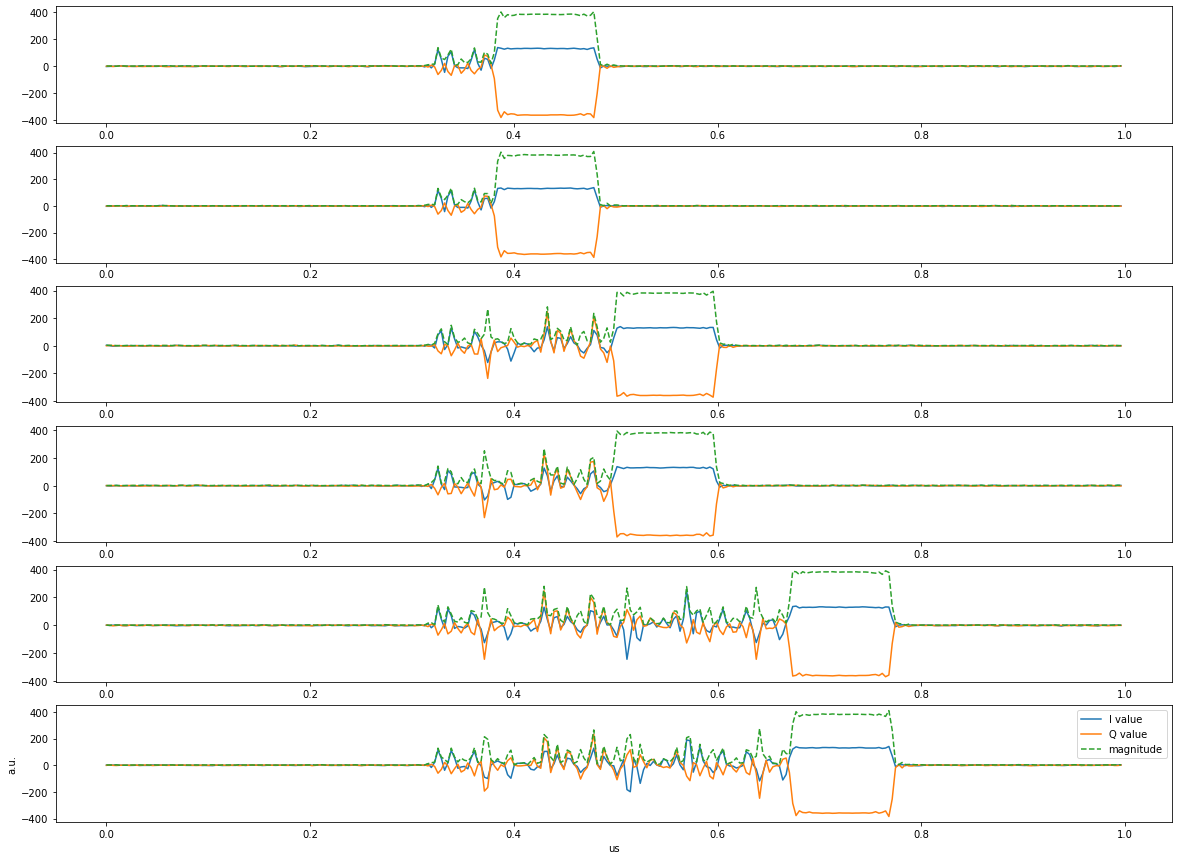

In [241]:
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.1
FREQ = 500
RO_LEN = 1.0
USE_LFSR = True
LFSR_SEED = 123456789
# LFSR_SEED = None
N_G = 1
L = [5, 15, 30]
# L = [3]
N_L = len(L)
N_E = 2

qubit_params = {'pi_gain': 1.0, 'pi_2_gain': 0.5, 'freq': FREQ, 'z_gain': 0.2}

# Define the Gates Set
"""Modeled the bloch sphere as 6-node graph, each rotation in the RB sequence is effectively
exchanging the node label on the bloch sphere.
For example: Z rotation is doing this: (+Z->+Z, -Z->-Z, +X->+Y, +Y->-X, -X->-Y, -Y->+X)
"""
"""Matrix columns are [Z, X, Y, -Z, -X, -Y]"""
GATES_SET = []
GATES_SET.append({  'gate_symbol': 'I',
                    'gate_matrix': np.matrix([[1, 0, 0, 0, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 0, 0, 0, 1]]
                                            ),
                    'gate_pulse':   {
                                        # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                        # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                        # "phase":0, "gain":0, "style":"arb",
                                        "style":        "arb",
                                        "envelope":     "gauss_env",
                                        "freq":         qubit_params['freq'],
                                        "phase":        0, 
                                        "gain":         0.1, 
                                    }
})
GATES_SET.append({  'gate_symbol': 'Z',
                    'gate_matrix': np.matrix([[1, 0, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['z_gain'],
                    }
})
GATES_SET.append({  'gate_symbol': 'X',
                    'gate_matrix': np.matrix([[0, 0, 0, 1, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 1, 0, 0, 0]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":qubit_params['pi_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['pi_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': 'Y',
                    'gate_matrix': np.matrix([[0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 0, 1]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "phase":-90, "gain":qubit_params['pi_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        -90, 
                                "gain":         qubit_params['pi_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': 'Z/2',
                    'gate_matrix': np.matrix([[1, 0, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['z_gain'],
                    }
})
GATES_SET.append({  'gate_symbol': 'X/2',
                    'gate_matrix': np.matrix([[0, 0, 1, 0, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [0, 0, 0, 0, 1, 0],
                                              [1, 0, 0, 0, 0, 0]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['pi_2_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': 'Y/2',
                    'gate_matrix': np.matrix([[0, 0, 0, 0, 1, 0],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 0, 1]]
                                    ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":-90, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        -90, 
                                "gain":         qubit_params['pi_2_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': '-Z/2',
                    'gate_matrix': np.matrix([[1, 0, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 0, 0, 0, 1],
                                              [0, 1, 0, 0, 0, 0]]
                                     ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":0, "gain":0, "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        0, 
                                "gain":         qubit_params['z_gain'],
                    }
})
GATES_SET.append({  'gate_symbol': '-X/2',
                    'gate_matrix': np.matrix([[0, 0, 0, 0, 0, 1],
                                              [0, 1, 0, 0, 0, 0],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [0, 0, 0, 1, 0, 0]]
                                     ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000),
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":180, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        180, 
                                "gain":         qubit_params['pi_2_gain'], 
                    }
})
GATES_SET.append({  'gate_symbol': '-Y/2',
                    'gate_matrix': np.matrix([[0, 1, 0, 0, 0, 0],
                                              [0, 0, 0, 1, 0, 0],
                                              [0, 0, 1, 0, 0, 0],
                                              [0, 0, 0, 0, 1, 0],
                                              [1, 0, 0, 0, 0, 0],
                                              [0, 0, 0, 0, 0, 1]]
                                     ),
                    'gate_pulse':   {
                                # "idata": gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "qdata": 0*gauss(mu=pi_sigma*16*4/2,si=pi_sigma*16,length=4*pi_sigma*16,maxv=32000), 
                                # "phase":90, "gain":qubit_params['pi_2_gain'], "style":"arb",
                                "style":        "arb",
                                "envelope":     "gauss_env",
                                "freq":         qubit_params['freq'],
                                "phase":        90, 
                                "gain":         qubit_params['pi_2_gain'], 
                    }
})


# Configure tProc LFSR to step on s1/s_rand read
soc.tproc.set_lfsr_cfg(2)

rb_config = {
                'gen_ch': GEN_CH,
                'ro_ch': RO_CH,
                'ro_len': RO_LEN,
                'freq': FREQ,
                'trig_time': TRIG_TIME,
                'relax_delay':0,
                'reps':1, 'rounds':1,
                'use_lfsr': USE_LFSR,
                'lfsr_seed': LFSR_SEED,
                'gates_set': GATES_SET,
                'N_G': N_G,
                'N_L': N_L,
                'L': L,
                'N_E': N_E
            }

prog = RBSequenceProgram(soccfg, reps=1, final_delay=0, cfg=rb_config)
iq_list = prog.acquire_decimated(soc, rounds=1)
t = prog.get_time_axis(ro_index=0)

plt.figure(figsize=[20,15])
N = len(iq_list[0])
for trig, iq in enumerate(iq_list[0]):
    plt.subplot(N,1,trig+1)
    plt.plot(t, iq[:,0], label="I value")
    plt.plot(t, iq[:,1], label="Q value")
    plt.plot(t, np.abs(iq.dot([1,1j])), label="magnitude", ls='--')
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")


# prog = RBSequenceProgram(soccfg, reps=1, final_delay=0.0, cfg=rb_config)
# iq_list = prog.acquire(soc, rounds=1)

# plt.figure(figsize=[20,10])
# plt.plot(np.abs(iq_list[0].dot([1,1j])), label="magnitude", ls='--')
# plt.legend()
# plt.ylabel("a.u.")



In [ ]:
# print the program
print(prog)

# generate rtl simulation inputs
prog.print_pmem2hex()
prog.print_wmem2hex()
prog.print_sg_mem(sg_idx=0, gen_file=True)